In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load sample data
df = pd.read_csv(r"C:\Users\AASHIK\Downloads\restockly_final_complete\sample_sales.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Product        10000 non-null  object        
 1   Date           10000 non-null  datetime64[ns]
 2   Quantity Sold  10000 non-null  float64       
 3   Price          10000 non-null  float64       
 4   Revenue        10000 non-null  float64       
 5   Location       10000 non-null  object        
 6   Category       10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 548.1+ KB


In [4]:
df.shape

(10020, 7)

In [5]:
df.size

70140

In [6]:
# Basic EDA
null = df.isnull().sum()
null

Product          20
Date             20
Quantity Sold    20
Price            20
Revenue          20
Location         20
Category         20
dtype: int64

In [7]:
df = df.dropna(axis=0)
df

,Product,Date,Quantity Sold,Price,Revenue,Location,Category
0,Product_11,2024-01-18,1.0,362.07,362.07,Chennai,Fashion
1,Product_29,2024-02-14,9.0,408.26,3674.34,Hyderabad,Fashion
2,Product_45,2024-03-23,7.0,143.69,1005.83,Chennai,Groceries
3,Product_30,2024-04-11,17.0,433.04,7361.68,Delhi,Beauty
4,Product_3,2024-01-28,11.0,150.73,1658.03,Mumbai,Stationery
...,...,...,...,...,...,...,...
10015,Product_20,2024-05-25,9.0,264.30,2378.70,Chennai,Fashion
10016,Product_10,2024-01-15,18.0,81.94,1474.92,Chennai,Stationery
10017,Product_37,2024-01-09,14.0,201.11,2815.54,Chennai,Fashion
10018,Product_12,2024-05-22,18.0,225.52,4059.36,Hyderabad,Beauty


In [8]:
duplicates = df.duplicated().sum()
duplicates

1000

In [9]:
df = df.drop_duplicates()
df.head()

,Product,Date,Quantity Sold,Price,Revenue,Location,Category
0,Product_11,2024-01-18,1.0,362.07,362.07,Chennai,Fashion
1,Product_29,2024-02-14,9.0,408.26,3674.34,Hyderabad,Fashion
2,Product_45,2024-03-23,7.0,143.69,1005.83,Chennai,Groceries
3,Product_30,2024-04-11,17.0,433.04,7361.68,Delhi,Beauty
4,Product_3,2024-01-28,11.0,150.73,1658.03,Mumbai,Stationery


In [10]:
df.shape

(9000, 7)

In [11]:
# Get list of valid products
all_products = df['Product'].dropna().unique()

full_data = []

for product in all_products:
    prod_df = df[df['Product'] == product].copy()
    prod_df = prod_df.groupby('Date')['Quantity Sold'].sum().reset_index()
    prod_df['Date'] = pd.to_datetime(prod_df['Date'])

    # Skip if product has no valid dates
    if prod_df['Date'].isna().all():
        continue

    if pd.isna(prod_df['Date'].min()) or pd.isna(prod_df['Date'].max()):
        continue

    # Create full daily date range
    full_dates = pd.date_range(start=prod_df['Date'].min(), end=prod_df['Date'].max())
    full_df = pd.DataFrame({'Date': full_dates})
    full_df = full_df.merge(prod_df, on='Date', how='left')
    full_df['Quantity Sold'].fillna(0, inplace=True)
    full_df['Product'] = product

    full_data.append(full_df)

# Combine all products into final DataFrame
df = pd.concat(full_data, ignore_index=True)


In [12]:
print("Top 5 selling products:")
print(df['Product'].value_counts().head())

Top 5 selling products:
Product
Product_25    181
Product_9     181
Product_27    181
Product_48    181
Product_32    181
Name: count, dtype: int64


In [13]:
# Aggregate sales per product per date
grouped = df.groupby(['Product', df['Date'].dt.date])['Quantity Sold'].sum().reset_index()
grouped['Date'] = pd.to_datetime(grouped['Date'])

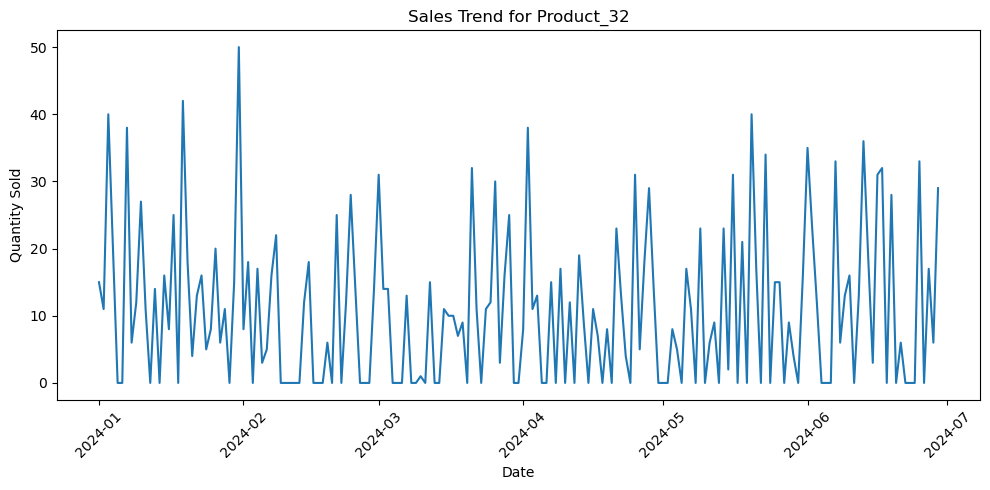

In [14]:
# Visualize sales trend for a top product
product_to_plot = grouped['Product'].value_counts().index[0]
sample_product = grouped[grouped['Product'] == product_to_plot]
plt.figure(figsize=(10,5))
sns.lineplot(data=sample_product, x='Date', y='Quantity Sold')
plt.title(f"Sales Trend for {product_to_plot}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Forecast and restock logic
restock_data = []
for product in grouped['Product'].unique():
    product_df = grouped[grouped['Product'] == product].sort_values("Date")
    product_df['Day'] = np.arange(len(product_df))

    if len(product_df) < 5:
        continue

    X = product_df[['Day']]
    y = product_df['Quantity Sold']
    model = LinearRegression()
    model.fit(X, y)

    future_days = np.array([[len(product_df) + i] for i in range(1, 8)])
    forecast = model.predict(future_days).sum()

    current_stock = 20
    buffer_stock = 5

    restock_data.append({
        'Product': product,
        'Forecasted Demand (7 Days)': round(forecast),
        'Current Stock': current_stock,
        'Recommended Restock': max(0, round(forecast) - current_stock + buffer_stock)
    })
    

In [16]:
restock_df = pd.DataFrame(restock_data)
print("\nSample Restock Plan:")
print(restock_df.head())



Sample Restock Plan:
      Product  Forecasted Demand (7 Days)  Current Stock  Recommended Restock
0   Product_1                          66             20                   51
1  Product_10                          68             20                   53
2  Product_11                          84             20                   69
3  Product_12                          77             20                   62
4  Product_13                          84             20                   69


In [17]:
# Export restock plan
restock_df.to_csv("restock_plan_output.csv", index=False)
print("\nRestock plan saved as 'restock_plan_output.csv'.")


Restock plan saved as 'restock_plan_output.csv'.
